# THE WAR AGAINST HEART ARRHYTHMIA

In [297]:
import numpy as np
from scipy.optimize import fsolve
import math
import pywt
import cython
import pandas as pd
import scipy.signal
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy import interpolate
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from statsmodels.tsa.stattools import acf
import random
from collections import deque
import statsmodels.graphics.tsaplots as st
from scipy import special
from scipy.signal import find_peaks
import sklearn
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy import integrate
import pyspeckit
from pyspeckit import moments
import arch
from arch.unitroot import VarianceRatio

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Signal preprocessing:

1. Subtract the mean
2. Five order moving average filtering
3. High Pass Filtering with f = 1 Hz (Drift Suppression)
4. low-pass Butterworth filtering with fc = 30 Hz

In [9]:
def signal_creator(MIT_signal_whole):
    MIT_data = []
    for i in range(len(MIT_signal_whole[0])):
        MIT_data.append(MIT_signal_whole[0][i][0])
    MIT_data = np.array(MIT_data)
    nulls = np.isnan(MIT_data)
    l=[]
    for i in range(len(nulls)):
        if nulls[i] == True:
            MIT_data[i] = 0
            l.append(i) 
    MIT_data[l] = np.mean(MIT_data)
    #plt.plot(MIT_data)
    #plt.xlim(0,600)
    return MIT_data


def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l) 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
    return result

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def starting_point(signal,t,fs):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = np.arange(signal_start.size)/fs
    return signal_start,time_M

def signal_preprocessor(data,time,uu,mm):
    mean = np.mean(data)
    data = data - mean
    
    data = moving_average(data,5)
    #plt.plot(time,data)
    #plt.xlim(0,10)
    data = np.array(data)
    
    data = butter_highpass_filter(data, 1, uu, 5)
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,data)
    
    MIT_signal = butter_lowpass_filter(data, 1, mm, 5)
    fs=30
    time = np.arange(MIT_signal.size)/fs
    time = time/10
    #figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.xlim((0, 10))
    #plt.plot(time,MIT_signal)

    return MIT_signal,time

def ready_signal(directory,freq1):
    s = wfdb.io.rdsamp(directory)
    s = signal_creator(s)
    t = np.arange(s.size)/freq1
    s = wfdb.processing.normalize_bound(s, lb=-1, ub=1)
    s,t= signal_preprocessor(s,t,freq1,30)
    return s,t

def starting_point_end(signal,t):
    M = np.amax(signal[0:300])
    index_M = np.where(signal==M)
    signal_start = signal[index_M[0][0]:-1]
    time_M = t[index_M[0][0]:-1]
    return signal_start,time_M

def start_end_ext(ss,tt):
    values = []
    time = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            x,y = starting_point_end(ss[i][j],tt[i][j])
            values.append(x)
            time.append(y)
    return values,time

## Signals and Times arrays:

In [10]:
signals = []
times = []
str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]
for i in MIT_str:
    x,y = ready_signal(str1+i,360)
    signals.append(x)
    times.append(y)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [11]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]
for i in cudb_str:
    x,y = ready_signal(str2+i,250)
    signals.append(x)
    times.append(y)

In [12]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]
for i in vfdb_str:
    x,y = ready_signal(str3+i,250)
    signals.append(x)
    times.append(y)

In [13]:
def for_sigmar(s,t):
    sigs = []
    tims = []
    for i in s:
        x = np.array_split(i,int(len(i)/3300))
        sigs.append(x)
    for i in t:
        y = np.array_split(i,int(len(i)/3300))
        tims.append(y)
    return sigs,tims

In [14]:
ss,tt = for_sigmar(signals,times)

In [15]:
sm,tm = start_end_ext(ss,tt)

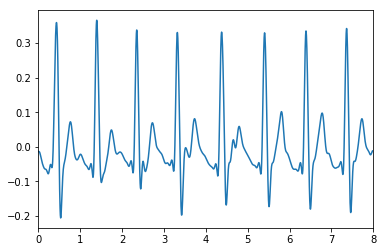

In [16]:
plt.xlim((0, 8))
#plt.ylim((930,1050))
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400])

In [17]:
for i in range(0,105):
    for j in range(len(ss[i])):
        if len(ss[i][j])!=len(tt[i][j]):
            print("oops")    ##Checking if time and signal are the same size, and they are!

In [18]:
for i in range(len(ss)):
    print("Signal number: ",i+1,"Number of signals: ",len(ss[i]))

Signal number:  1 Number of signals:  196
Signal number:  2 Number of signals:  196
Signal number:  3 Number of signals:  196
Signal number:  4 Number of signals:  196
Signal number:  5 Number of signals:  196
Signal number:  6 Number of signals:  196
Signal number:  7 Number of signals:  196
Signal number:  8 Number of signals:  196
Signal number:  9 Number of signals:  196
Signal number:  10 Number of signals:  196
Signal number:  11 Number of signals:  196
Signal number:  12 Number of signals:  196
Signal number:  13 Number of signals:  196
Signal number:  14 Number of signals:  196
Signal number:  15 Number of signals:  196
Signal number:  16 Number of signals:  196
Signal number:  17 Number of signals:  196
Signal number:  18 Number of signals:  196
Signal number:  19 Number of signals:  196
Signal number:  20 Number of signals:  196
Signal number:  21 Number of signals:  196
Signal number:  22 Number of signals:  196
Signal number:  23 Number of signals:  196
Signal number:  24 N

In [19]:
def annotation_symbols(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.aux_note)
    return np.array(ann_list)

def annotation_locations(str1,str2):
    ann = wfdb.rdann(str1+str2, 'atr')
    ann_list = np.array(ann.sample)
    return np.array(ann_list)

In [20]:
ann_list =[]
ann_locations = []

str1 = "./Data_thesis/MIT/"
MIT_str = ["100","101","102","103","104","105","106","107","108","109","111","112","113","114","115","116","117","118","119",
           "121","122","123","124","200","201","202","203","205","207","208","209","210","212","213","214","215","217",
           "219","220","221","222","223","228","230","231","232","233","234"]

for i in MIT_str:
    ann_list.append(annotation_symbols(str1,i))
    ann_locations.append(annotation_locations(str1,i))

In [21]:
str2 = "./Data_thesis/CUDB/"
cudb_str = ["cu01","cu02","cu03","cu04","cu05","cu06","cu07","cu08","cu09","cu10","cu11","cu12","cu13","cu14","cu15","cu16",
            "cu17","cu18","cu19","cu20","cu21","cu22","cu23","cu24","cu25","cu26","cu27","cu28","cu29","cu30","cu31","cu32",
            "cu33","cu34","cu35"]

for i in cudb_str:
    ann_list.append(annotation_symbols(str2,i))
    ann_locations.append(annotation_locations(str2,i))

In [22]:
str3 = "./Data_thesis/VFDB/"
vfdb_str = ["418","419","420","421","422","423","424","425","426","427","428","429","430","602","605","607",
            "609","610","611","612","614","615"]

for i in vfdb_str:
    ann_list.append(annotation_symbols(str3,i))
    ann_locations.append(annotation_locations(str3,i))

In [23]:
ann_list=np.array(ann_list)
ann_locations = np.array(ann_locations)

In [24]:
ann_list

array([array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['', '(N', '', ..., '', '', ''], dtype='<U4'),
       array(['(P', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U2'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U6'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '', ''], dtype='<U3'),
       array(['(N', '', '', ..., '', '',

In [25]:
ann_locations

array([array([    18,     77,    370, ..., 649484, 649734, 649991]),
       array([     7,     83,    396, ..., 649004, 649372, 649751]),
       array([    68,    136,    410, ..., 649244, 649553, 649852]),
       array([    21,    265,    575, ..., 649195, 649534, 649875]),
       array([    36,     73,    316, ..., 649300, 649580, 649876]),
       array([    67,    197,    459, ..., 649221, 649471, 649740]),
       array([    83,    229,    351, ..., 649162, 649340, 649791]),
       array([    47,     95,    272, ..., 649129, 649441, 649748]),
       array([    23,     88,    442, ..., 649170, 649471, 649769]),
       array([    18,    111,    343, ..., 649378, 649663, 649931]),
       array([    31,    197,    489, ..., 649148, 649441, 649724]),
       array([    15,    124,    382, ..., 649361, 649626, 649883]),
       array([    22,    170,    583, ..., 649364, 649675, 649994]),
       array([    21,    310,    726, ..., 649261, 649523, 649783]),
       array([    44,    161,    5

In [26]:
wfdb.io.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [27]:
wfdb.io.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


In [28]:
def fib_location(lis,loc):
    listlist = []
    listmist = []
    for i in range(len(lis)):
        for j in range(len(lis[i])):
            if lis[i][j]== '(VF' or lis[i][j] == '(VT' or lis[i][j] == '(VFL' or lis[i][j] == '(VF' or lis[i][j] == '(SVTA':
                for k in range(len(ann_list[i][j+1:-1])):
                    if ann_list[i][j+k+1] != '':
                        lastone = loc[i][j+k]
                        duration = lastone - loc[i][j-1]
                        break
                if i <=47:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Duration: ",duration/300,"s"," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", ((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])),"until: ",((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append(((i)*len(ss[i]))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append(((i)*len(ss[i]))+int(loc[i][j+k]/len(ss[i][0])))
                elif 47 < i < 83: 
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-47)*len(ss[i]))+(196*47))+int(loc[i][j+k]/len(ss[i][0])))
                elif i >= 83:
                    print("Signal number: ",i+1," Type: ",lis[i][j]," Location: ",loc[i][j]," Location in Signal division = ",int(loc[i][j]/len(ss[i][0]))," Location in vertical labels = ", (((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])),"until: ",(((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
                    listlist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j]/len(ss[i][0])))
                    listmist.append((((i-82)*len(ss[i]))+(196*47)+(38*34))+int(loc[i][j+k]/len(ss[i][0])))
    return np.array(listlist),np.array(listmist)

In [29]:
VFVT_labels = [0.0]*14236
VFVT_labels = np.array(VFVT_labels)
Y_loc= fib_location(ann_list,ann_locations)

Signal number:  7  Type:  (VT  Location:  63624  Duration:  1.7866666666666666 s  Location in Signal division =  19  Location in vertical labels =  1195 until:  1195
Signal number:  14  Type:  (SVTA  Location:  251900  Duration:  5.233333333333333 s  Location in Signal division =  75  Location in vertical labels =  2623 until:  2624
Signal number:  24  Type:  (VT  Location:  39210  Duration:  2.2066666666666666 s  Location in Signal division =  11  Location in vertical labels =  4519 until:  4519
Signal number:  24  Type:  (VT  Location:  226766  Duration:  1.7166666666666666 s  Location in Signal division =  68  Location in vertical labels =  4576 until:  4576
Signal number:  24  Type:  (VT  Location:  340338  Duration:  3.0 s  Location in Signal division =  102  Location in vertical labels =  4610 until:  4610
Signal number:  24  Type:  (VT  Location:  385419  Duration:  1.9133333333333333 s  Location in Signal division =  116  Location in vertical labels =  4624 until:  4624
Signal 

Signal number:  31  Type:  (SVTA  Location:  550895  Duration:  3.0766666666666667 s  Location in Signal division =  166  Location in vertical labels =  6046 until:  6046
Signal number:  31  Type:  (SVTA  Location:  617455  Duration:  2.033333333333333 s  Location in Signal division =  186  Location in vertical labels =  6066 until:  6066
Signal number:  31  Type:  (SVTA  Location:  618287  Duration:  6.75 s  Location in Signal division =  186  Location in vertical labels =  6066 until:  6066
Signal number:  31  Type:  (SVTA  Location:  631897  Duration:  3.1366666666666667 s  Location in Signal division =  190  Location in vertical labels =  6070 until:  6070
Signal number:  32  Type:  (VT  Location:  151554  Duration:  2.94 s  Location in Signal division =  45  Location in vertical labels =  6121 until:  6121
Signal number:  32  Type:  (VT  Location:  389830  Duration:  3.6766666666666667 s  Location in Signal division =  117  Location in vertical labels =  6193 until:  6193
Signal n

Signal number:  84  Type:  (VFL  Location:  339769  Location in Signal division =  102  Location in vertical labels =  10765 until:  10765
Signal number:  84  Type:  (VFL  Location:  346634  Location in Signal division =  104  Location in vertical labels =  10767 until:  10767
Signal number:  84  Type:  (VFL  Location:  347403  Location in Signal division =  105  Location in vertical labels =  10768 until:  10768
Signal number:  84  Type:  (VFL  Location:  357634  Location in Signal division =  108  Location in vertical labels =  10771 until:  10771
Signal number:  84  Type:  (VFL  Location:  362711  Location in Signal division =  109  Location in vertical labels =  10772 until:  10772
Signal number:  84  Type:  (VFL  Location:  367749  Location in Signal division =  111  Location in vertical labels =  10774 until:  10774
Signal number:  84  Type:  (VFL  Location:  368583  Location in Signal division =  111  Location in vertical labels =  10774 until:  10774
Signal number:  84  Type:  

Signal number:  87  Type:  (VT  Location:  302538  Location in Signal division =  91  Location in vertical labels =  11231 until:  11231
Signal number:  87  Type:  (VT  Location:  303634  Location in Signal division =  91  Location in vertical labels =  11231 until:  11231
Signal number:  87  Type:  (VT  Location:  305153  Location in Signal division =  92  Location in vertical labels =  11232 until:  11232
Signal number:  87  Type:  (VT  Location:  306134  Location in Signal division =  92  Location in vertical labels =  11232 until:  11232
Signal number:  87  Type:  (VT  Location:  307230  Location in Signal division =  93  Location in vertical labels =  11233 until:  11233
Signal number:  87  Type:  (VT  Location:  308442  Location in Signal division =  93  Location in vertical labels =  11233 until:  11233
Signal number:  87  Type:  (VT  Location:  309807  Location in Signal division =  93  Location in vertical labels =  11233 until:  11233
Signal number:  87  Type:  (VT  Location:

Signal number:  99  Type:  (VT  Location:  471519  Location in Signal division =  142  Location in vertical labels =  13190 until:  13190
Signal number:  99  Type:  (SVTA  Location:  473673  Location in Signal division =  143  Location in vertical labels =  13191 until:  13191
Signal number:  100  Type:  (VFL  Location:  255275  Location in Signal division =  77  Location in vertical labels =  13284 until:  13284
Signal number:  100  Type:  (VT  Location:  291506  Location in Signal division =  88  Location in vertical labels =  13295 until:  13295
Signal number:  101  Type:  (VT  Location:  459865  Location in Signal division =  139  Location in vertical labels =  13505 until:  13505
Signal number:  102  Type:  (SVTA  Location:  38  Location in Signal division =  0  Location in vertical labels =  13525 until:  13525
Signal number:  102  Type:  (VT  Location:  299057  Location in Signal division =  90  Location in vertical labels =  13615 until:  13615
Signal number:  103  Type:  (VT  

In [30]:
i = 0
counter = 0
while 3 > 2:
    for l in range(Y_loc[0][i],Y_loc[1][i]+1):
        VFVT_labels[l] = 1.0
        counter+=1
    i+=1
    if i == 305:
        break

In [31]:
VFVT_labels

array([0., 0., 0., ..., 0., 0., 0.])

In [32]:
lismis = []
for i in range(len(VFVT_labels)):
    if VFVT_labels[i] == 1: 
        lismis.append(i)

In [33]:
len(lismis)

283

In [73]:
counter = 0
for i in lismis:
   # if comp_measure(ss[2][2][0:2400],2400) >= 0.173:
   #     counter +=1  

SyntaxError: unexpected EOF while parsing (<ipython-input-73-a1e8f717fe45>, line 4)

In [75]:
counter

121

# Time parameter

In [40]:
t_cst = len(ss[0][0])/tt[0][0][-1]
t_cst  ##number of signal points in 1 second

300.09047044632086

## Parameter 1: TCI

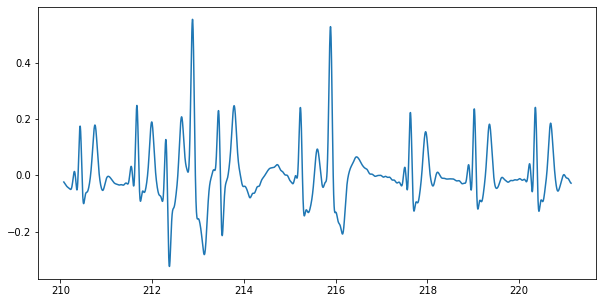

In [41]:
ss[6][19].size
tt[6][19].size
plt.figure(figsize=(10,5))
plt.plot(tt[6][19],ss[6][19])

In [42]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

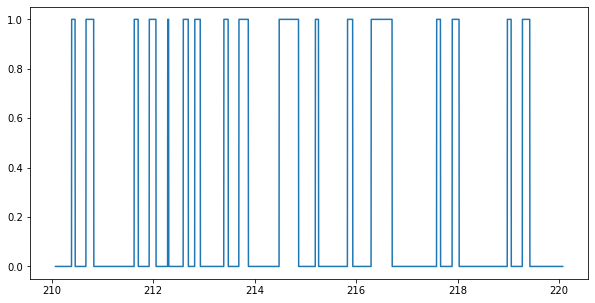

In [43]:
binlist,thd = binary_td(ss[6][19],0,10)
plt.figure(figsize=(10,5))
plt.plot(tt[6][19][0:10*300],binlist)
binlist[300:2700]

In [44]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        if t1+t2 == 0:
            TCI.append(0)
        elif t3+t4==0:
            TCI.append(0)
        else:
            form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
            if form1 == 0:
                TCI.append(0)
            else:
                form2=1000/form1
                TCI.append(form2)
            q+=300
            p+=300
            k+=1
    return np.array(TCI)

In [45]:
binlist,thd = binary_td(ss[6][19],0,10)
TCI(binlist,thd,1,9)

array([562.62558607, 309.73451327, 496.62712259, 767.97179907,
       567.88848735, 974.88921713, 612.63834345, 960.98294885])

## TCI Extraction:

In [62]:
def TCI_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            binlist,thd = binary_td(ss[i][j],0,10)
            values.append(TCI(binlist,thd,1,9))
    return np.array(values)

In [64]:
TCI = TCI_ext(ss)

In [65]:
TCI[0]

array([ 985.71428571,  951.04646136,  950.16888638,  941.09609647,
        974.68877589,  866.32910041, 1670.37989146,  795.03305918])

In [66]:
l = []
for i in TCI:
     l.append([pd.DataFrame({ i[0],i[1],i[2],i[3],i[4],i[5],i[6],i[7] })])
ll = []
for i in l:
    ll.append(pd.DataFrame(i))
TCI_DF = pd.concat(ll)
TCI_DF.columns = ["TCI"]

In [67]:
TCI_DF

,TCI
0,0 0 866.329100 1 1670.379891 2...
0,0 0 954.516496 1 961.907372 2...
0,0 0 932.685362 1 1002.087758 2...
0,0 0 993.735132 1 961.845837 2...
0,0 0 1121.418827 1 962.612343 2...
0,0 0 993.598333 1 1001.035468 2...
0,0 0 965.953556 1 1160.825732 2...
0,0 0 961.191943 1 963.171929 2...
0,0 0 963.378322 1 996.601571 2 9...
0,0 0 1025.644765 1 1025.057499 2...


# Parameter 2: ACF Algorithm

In [50]:
qrs_inds = processing.xqrs_detect(sig=ss[2][0][0:2400], fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

44

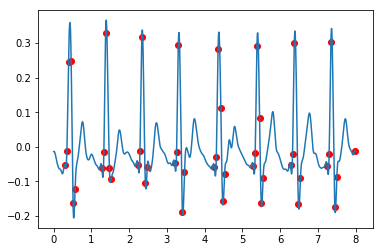

In [52]:
plt.plot(tt[2][0][0:2400],ss[2][0][0:2400])
plt.scatter(tt[2][0][qrs_inds],ss[2][0][qrs_inds],color="red")
x = int(len(qrs_inds))
x

In [57]:
ser = acf(ss[2][0][0:2400],nlags=x,alpha=0.01)

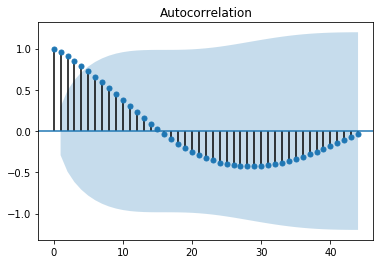

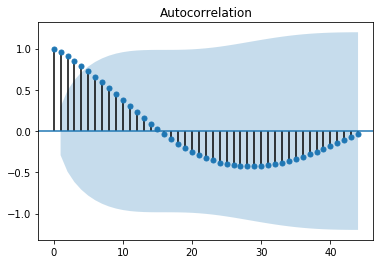

In [58]:
st.plot_acf(ser[0])

In [59]:
vr = VarianceRatio(ser[0])
vr.overlap=False
vr.stat

4.641282036531771

In [218]:
def ACF_test(signal):
    qrs_inds = processing.xqrs_detect(sig=signal, fs=55)
    x = int(len(qrs_inds))
    ser = acf(signal,nlags=x,alpha=0.05)
    vr = VarianceRatio(ser[0])
    vr.overlap=False
    return vr.stat

In [219]:
ACF_test(ss[2][0][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


4.641282036492195

## ACF Extraction:

In [63]:
def ACF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(ACF_test(ss[i][j][0:2400]))
    return np.array(values)

In [ ]:
#ACF = ACF_ext(ss)

In [ ]:
ACF

In [ ]:
ACF_DF = pd.DataFrame(ACF)
ACF_DF.columns = ["ACF"]

In [ ]:
ACF_DF

## Parameter 3: VF Filter

In [48]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def VF_Filter_leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [49]:
VF_Filter_leakage(ss[2][0][0:2400],int(get_points(ss[2][0][0:2400],300)),200,500)

0.634487213285533

## VF Filter Extraction

In [ ]:
def VFF_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(VF_Filter_leakage(ss[i][j][0:2400],int(get_points(ss[i][j][0:2400],300)),200,500))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["VFF"]
    return v

In [ ]:
VFF_DF = VFF_ext(ss)

## Parameter 4: Spectral Algorithm

In [29]:
Ham = MIT_signal[0:2400]*np.hamming(2400)

(-120, 120)

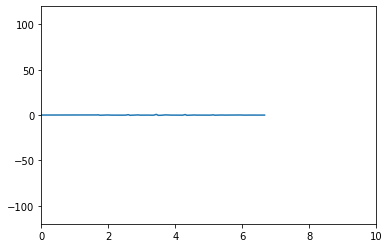

In [30]:
plt.plot(time[0:2400],Ham)
plt.xlim(0,10)
plt.ylim(-120,120)

In [31]:
fourier = scipy.fft(Ham)

In [32]:
fourier

array([-0.22628347+0.j        , -0.22701253+0.02394437j,
       -0.23126225+0.04699765j, ..., -0.22889275-0.10295006j,
       -0.23126225-0.04699765j, -0.22701253-0.02394437j])

Casting complex values to real discards the imaginary part


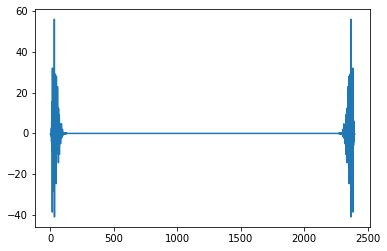

In [33]:
plt.plot(fourier)

In [34]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [35]:
fourier_2 = fourier_abs(fourier).real

In [36]:
fourier_2

array([0.22628347, 0.2509569 , 0.2782599 , ..., 0.33184282, 0.2782599 ,
       0.2509569 ])

(0, 10)

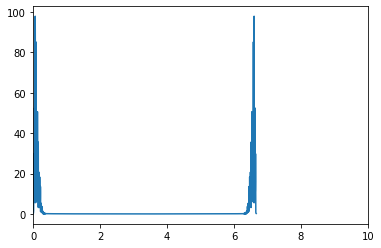

In [37]:
plt.plot(time[0:2400],fourier_2)
plt.xlim(0,10)

In [38]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [39]:
time_2

2.0

In [40]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

13
50.614812928583326


In [41]:
f.index(m)

13

In [42]:
f[6]

25.378390237140998

In [43]:
time_max_amp = f.index(m)/300 ## in seconds
if time_max_amp != 0:
    God_of_War = 1/time_max_amp
else:
    God_of_War = 0
God_of_War

23.076923076923077

In [44]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [45]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([0., 0., 0., ..., 0., 0., 0.])

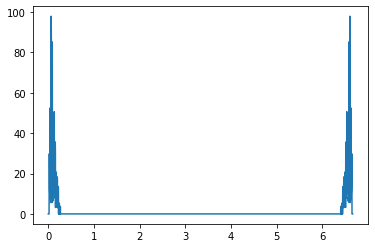

In [46]:
plt.plot(time[0:2400],fourier_final)

In [47]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


<Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at -0x7fffffe57d57ef1c>

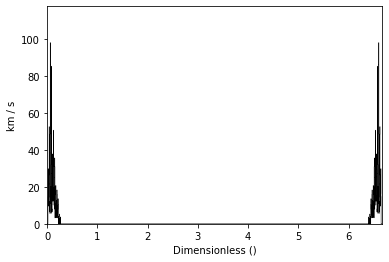

In [48]:
pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],doplot="True",unit ='km / s' )

In [49]:
Mk = pyspeckit.spectrum.Spectrum(data = fourier_final,xarr = time[0:2400],unit = 'km / s').moments
Mk

<bound method BaseSpectrum.moments of <Spectrum object named  over spectral range      0 : 6.6639  and flux range = [0.0, 97.9] km / s at 0x1a82a82b86>>

In [50]:
np.minimum(1,2)

1

In [51]:
sum(MIT_signal[0:2400])

-2.938399091551117

In [52]:
def A_calc(f1,f2,f3,f4,signal):
    i1 = int((f1)*300)
    i2 = int((f2)*300)
    i3 = int((f3)*300)
    i4 = int((f4)*300)
    
    if i1<i2:
        A=0
        for i in range(len(signal[i1:i2])):
            A += signal[i]
    else:
        A=0
        for i in range(len(signal[i2:i1])):
            A += signal[i]
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])

    return (A/B)

In [53]:
A1 = A_calc(0.5,God_of_War/2,0.5,np.minimum(20*God_of_War,100),fourier_final)
A1

1.0000000000000007

In [54]:
A2 = A_calc(0.7*God_of_War,1.4*God_of_War,0.5,np.minimum(20*God_of_War,100),MIT_signal[0:2400])
A2

-0.0

In [55]:
A = np.arange(2*God_of_War,8*God_of_War,0.6)
A = ((1/A)*t_cst).astype(int)
A = np.unique(A)
A

array([1, 2, 3, 4, 5, 6, 7])

In [56]:
def A3_calc(signal,God_of_War):
    A = np.arange(2*God_of_War,8*God_of_War,0.6)
    A = ((1/A)*t_cst).astype(int)
    A = np.unique(A)
    A = sum(signal[A])
    
    i3 = int((1/0.5)*300)
    i4 = int(1/np.minimum(20*God_of_War,100))
    
    if i3<i4:
        B = sum(signal[i3:i4])
    else:
        B = sum(signal[i4:i3])
    return A/B

In [57]:
A3_calc(MIT_signal[0:2400],God_of_War)

-1.0240904109272688

In [58]:
def SPEC(signal):
    Ham = signal*np.hamming(2400)
    fourier = scipy.fft(Ham)
    fourier_2 = fourier_abs(fourier).real
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = fourier_2[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    fourier_final = amp_maxsetter(fourier_2,m)
    
    A3 = A3_calc(fourier_2,God_of_War)
    
    return A3

In [59]:
SPEC(MIT_signal[0:2400])

0.009584663943600327

## Spectral Extraction:

In [ ]:
def SPEC_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SPEC(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SPEC"]
    return v

In [ ]:
SPEC_DF = SPEC_ext(ss)

## Parameter 5: Complexity Measure Algorithm

In [63]:
nurgle = ss[2][0][0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

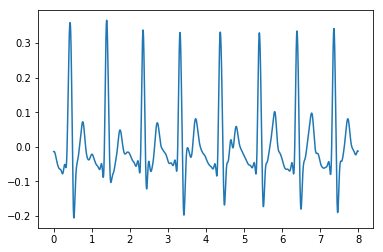

In [64]:
plt.plot(tt[2][0][0:2400],nurgle)

In [65]:
def Td(nurgle):
    meanbean = np.mean(nurgle)
    nurgle = nurgle - meanbean
    Vp = np.amax(nurgle)
    Vn = np.amin(nurgle)
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [66]:
Threshold = Td(nurgle)
Threshold

0

In [67]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [68]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [69]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary,length):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    bn = length/(math.log2(length))
    
    return cn/bn

In [70]:
def complexity_measure(nurgle,length):
    Threshold = Td(nurgle)
    binary = binary_comp(Threshold,nurgle)
    return complexity(binary,length)

In [71]:
def comp_measure(signal,length):
    l = 0
    k = 0
    j = 300
    for i in range(0,8):
        l += complexity_measure(signal[k:j],length)
        k+=300
        j+=300
    return l

In [72]:
comp_measure(ss[2][2][0:2400],2400) ## use an AWS for this

KeyboardInterrupt: 

## Complexity Measure Extraction:

In [ ]:
def Comp_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(comp_measure(ss[i][j][0:2400],2400))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["Complexity"]
    return v

In [ ]:
Comp_DF = Comp_ext(ss)

## Parameter 6: Standard Exponential Algorithm

In [200]:
def std_exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    #plt.figure(figsize=(20,10))
    #plt.plot(t,signal)
    #plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    #plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

In [201]:
std_exp_algthm(tt[2][0][0:2400],ss[2][0][0:2400],3)

165.0

In [87]:
time

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [88]:
tt[0][0]

array([0.00000000e+00, 3.33333333e-03, 6.66666667e-03, ...,
       1.10466667e+01, 1.10500000e+01, 1.10533333e+01])

## Standard Exponential Extraction:

In [89]:
def stdexp_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(std_exp_algthm(tt[i][j][0:2400],ss[i][j][0:2400],3))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["ST_EXP"]
    return v

In [ ]:
ST_EXP_DF = stdexp_ext(ss,tt) 

In [ ]:
ss[0][0][0:2400]

## Parameter 7: Modified Exponential Algorithm

In [40]:
def MEA(t,signal,Tau):
    real_curve = [0.0]*len(t)
    index_M  = argrelextrema(signal,np.greater)
    idx_M = index_M[0]
    gladiator = np.amax(signal)
    idx_M2 = []
    for i in idx_M:
        if signal[i]>0.2*gladiator:
            idx_M2.append(i)
    idx_M2 = np.array(idx_M2)
    idx_M1 = []
    for i in idx_M:
        if signal[i]>0.1*gladiator:
            idx_M1.append(i)
    idx_M1 = np.array(idx_M1)
    
    ## draw the first curve
    pt = 0
    qqq = 0
    lifts=0
    while 2 < 3: 
        if pt >= idx_M[-1]: 
            break
        M1 = signal[pt]
        tm1 = t[pt]
        curve_1 = M1*np.exp(-1*(t-tm1)/(Tau))
        idx_1 = np.argwhere(np.diff(np.sign(signal-curve_1))).flatten()
        for i in idx_1:
            if i > 11+pt:
                idx_work = i
                break
        ## find all the maxes 
        for j in range(len(idx_M)):
            if idx_work <= idx_M[j]:
                idx_M_work = idx_M[j]
                break
        real_curve[pt:idx_work] = (curve_1[pt:idx_work])
        real_curve[idx_work:idx_M_work]=(signal[idx_work:idx_M_work])
        pt = idx_M_work
        if pt ==qqq:
            break
        qqq = idx_M_work
        lifts+=1
        if pt >= idx_M[-1]:     
            break
    idx_final = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    #plt.figure(figsize=(20,10))
    #plt.plot(t,signal,color="blue")
    #plt.plot(t,real_curve,color="green")
    #plt.plot(t[idx_final],signal[idx_final],'ro')
    pt=idx_M_work
    Time_length = t[-1]-t[0]
    form = lifts/Time_length
    return form*60

In [41]:
MEA(tm[1195][0:2400],sm[1195][0:2400],0.2)

127.55314714464356

## Modified Exponential Extraction:

In [108]:
def MEA_ext(ss,tt):
    values = []
    for i in range(len(ss)):
        values.append(MEA(tt[i][0:-1],ss[i][0:-1],0.2))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["MDF_EXP"]
    return v

In [109]:
MEA_DF = MEA_ext(sm,tm)

NameError: name 'MEA' is not defined

In [110]:
MEA_DF

NameError: name 'MEA_DF' is not defined

## Parameter 8: Signal Comparison

In [115]:
lismis

[1195,
 2623,
 2624,
 4519,
 4576,
 4610,
 4624,
 4627,
 4631,
 4670,
 4876,
 5101,
 5105,
 5106,
 5107,
 5125,
 5128,
 5129,
 5151,
 5165,
 5173,
 5176,
 5178,
 5180,
 5212,
 5218,
 5220,
 5221,
 5226,
 5258,
 5270,
 5273,
 5280,
 5324,
 5325,
 5392,
 5450,
 5451,
 5452,
 5492,
 5493,
 5494,
 5514,
 5515,
 5516,
 5517,
 5518,
 5655,
 5656,
 5657,
 5658,
 5659,
 5660,
 5661,
 5662,
 5663,
 5664,
 5665,
 5678,
 5679,
 5680,
 5681,
 5682,
 5683,
 5925,
 5926,
 5940,
 5941,
 5942,
 5943,
 5945,
 5946,
 5947,
 5959,
 5960,
 5961,
 5966,
 5967,
 5973,
 5974,
 6046,
 6066,
 6070,
 6121,
 6193,
 6565,
 6582,
 6701,
 6754,
 6755,
 6879,
 6993,
 7102,
 7492,
 7493,
 7494,
 7517,
 7518,
 7581,
 7582,
 7729,
 7735,
 7917,
 7980,
 7981,
 7983,
 8098,
 8099,
 8100,
 8101,
 8102,
 8103,
 8104,
 8117,
 8145,
 8146,
 8149,
 8150,
 8151,
 8152,
 8153,
 8192,
 8204,
 8215,
 9018,
 9019,
 9079,
 9162,
 9164,
 9206,
 9265,
 9302,
 9303,
 9304,
 9305,
 9306,
 9324,
 9325,
 9360,
 10693,
 10703,
 10704,
 10

In [249]:
SCA(sm[411][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

array([0.33677556, 0.25352041, 0.8094834 ])

In [120]:
signal = sm[14040][0:2400]
signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
time_1 = tm[14040][0:2400]
qrs_inds = processing.xqrs_detect(sig=signal, fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

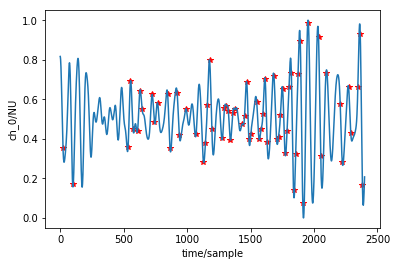

array([  22,   98,  535,  554,  574,  610,  628,  645,  725,  743,  767,
        847,  865,  922,  939,  993, 1071, 1129, 1145, 1160, 1177, 1195,
       1279, 1295, 1310, 1325, 1342, 1360, 1376, 1436, 1453, 1470, 1487,
       1503, 1549, 1567, 1583, 1598, 1615, 1631, 1685, 1705, 1721, 1736,
       1753, 1772, 1788, 1804, 1822, 1839, 1856, 1874, 1892, 1912, 1956,
       2036, 2053, 2095, 2207, 2223, 2273, 2290, 2346, 2365, 2382])

In [121]:
wfdb.plot_items(signal=signal, ann_samp=[qrs_inds])
qrs_inds

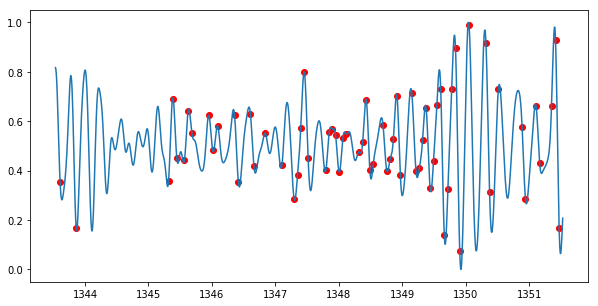

In [122]:
plt.figure(figsize=(10,5))
plt.plot(time_1,signal)
plt.scatter(time_1[qrs_inds],signal[qrs_inds],color="red")

Let's create the first signal:

In [214]:
MIT_signal_1 = sm[196*2]
time_1 = tm[196*2]

Adjust the peaks to match the QRS points found for the signal we want to examine:

In [215]:
SCA_1 = MIT_signal_1[0:2400]
qrs_inds_2 = processing.xqrs_detect(sig=SCA_1, fs=55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

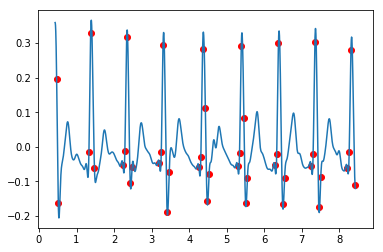

In [216]:
plt.plot(time_1[0:2400],SCA_1)
plt.scatter(time_1[qrs_inds_2],SCA_1[qrs_inds_2],color = "red")

Now to create the second signal:

In [221]:
avg = [sm[196][0:2400],sm[196*3][0:2400],sm[196*5][0:2400],sm[196*6][0:2400],sm[196*8][0:2400],sm[196*9][0:2400],sm[196*10][0:2400],sm[196*11][0:2400],
       sm[196*12][0:2400],sm[196*13][0:2400],sm[196*14][0:2400],sm[196*15][0:2400],sm[196*16][0:2400],sm[196*17][0:2400],sm[196*18][0:2400],sm[196*19][0:2400]]
avg = np.array(avg)

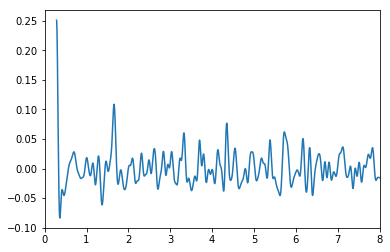

In [224]:
SCA_2 = sum(avg)/len(avg)
plt.xlim(0,8)
plt.plot(tm[196][0:2400],SCA_2)

In [226]:
SCA_2 = sm[196*3]

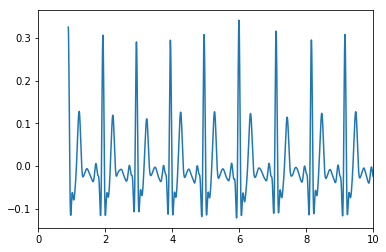

In [227]:
plt.xlim(0,10)
plt.plot(tm[196*3],SCA_2)

Now for the third signal, it just has an elevated T wave:

In [228]:
SCA_3 = sm[196*7]
time_third = tm[196*7]

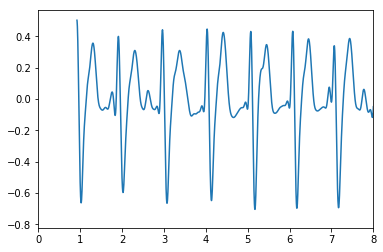

In [229]:
plt.xlim(0,8)
plt.plot(time_third,SCA_3)

For the fourth signal:

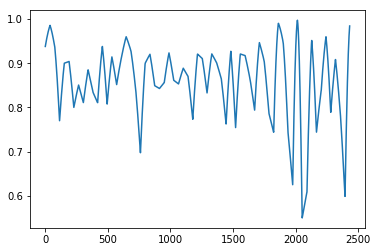

In [230]:
x = []
spacing1 = len(signal)/(len(qrs_inds)-1)
for i in range(len(signal[qrs_inds])-1):
    spacing2 = (signal[qrs_inds[i+1]] - signal[qrs_inds[i]])/spacing1
    y = np.arange(signal[qrs_inds[i]],signal[qrs_inds[i+1]],spacing2) ##Needs to be a formula
    for i in y:
        x.append(i)
x = np.array(x)
SCA_4 = np.cos(x)
plt.plot(SCA_4)
len(SCA_4)
SCA_4 = np.resize(SCA_4,(2400,))

Now for the residual calculation

In [231]:
I0 = qrs_inds[0]
I1 = qrs_inds[-1]

In [232]:
def Integral_calc(S,F,I0,I1):
    y = np.absolute(S-F)
    R = integrate.simps(y[I0:I1])
    return R

In [233]:
RF   = Integral_calc(signal,SCA_4,I0,I1)
RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
print("RF = ",RF)
print("RFS1 = ",RFS1)
print("RFS2 = ",RFS2)
print("RFS3 = ",RFS3)

RF =  846.7305858861204
RFS1 =  1202.621460301758
RFS2 =  1201.3259437041631
RFS3 =  1213.1046183398212


In [234]:
IF  = Integral_calc(SCA_4,0,I0,I1)
IE  = Integral_calc(signal,0,I0,I1)
IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)

print("IF = ",IF)
print("IE = ",IE)
print("IS1 = ",IS1)
print("IS2 = ",IS2)
print("IS3 = ",IS3)

IF =  2026.551034592044
IE =  1200.1275866270544
IS1 =  160.89000743830337
IS2 =  122.80118761734005
IS3 =  409.5392932054313


In [235]:
VRF = (RF/min(IF,IE))
VRS1 = RFS1/min(IS1,IE)
VRS2 = RFS2/min(IS2,IE)
VRS3 = RFS3/min(IS3,IE)

print("VRF = ",VRF)
print("VRS1 = ",VRS1)
print("VRS2 = ",VRS2)
print("VRS3 = ",VRS3)

VRF =  0.7055338076727722
VRS1 =  7.474805175597547
VRS2 =  9.782689947980037
VRS3 =  2.962120212800458


In [236]:
t1 = VRF/VRS1
t2 = VRF/VRS2
t3 = VRF/VRS3

print("t1 = ",t1)
print("t2 = ",t2)
print("t3 = ",t3)

t1 =  0.09438825375356633
t2 =  0.07212063465411711
t3 =  0.23818540673126296


In [410]:
x= [1,2,3]
np.array(x)

array([1, 2, 3])

In [238]:
def SCA(signal):
    
    signal = wfdb.processing.normalize_bound(signal, lb=0, ub=1)
    qrs_inds = processing.xqrs_detect(sig=signal, fs=85)
    
    I0 = qrs_inds[0]
    I1 = qrs_inds[-1]
    
    RF   = Integral_calc(signal,SCA_4,I0,I1)
    RFS1 = Integral_calc(signal,SCA_1[0:2400],I0,I1)
    RFS2 = Integral_calc(signal,SCA_2[0:2400],I0,I1)
    RFS3 = Integral_calc(signal,SCA_3[0:2400],I0,I1)
    IF  = Integral_calc(SCA_4,0,I0,I1)
    IE  = Integral_calc(signal,0,I0,I1)
    IS1 = Integral_calc(SCA_1[0:2400],0,I0,I1)
    IS2 = Integral_calc(SCA_2[0:2400],0,I0,I1)
    IS3 = Integral_calc(SCA_3[0:2400],0,I0,I1)
    VRF = (RF/min(IF,IE))
    VRS1 = RFS1/min(IS1,IE)
    VRS2 = RFS2/min(IS2,IE)
    VRS3 = RFS3/min(IS3,IE)
    t1 = VRF/VRS1
    t2 = VRF/VRS2
    t3 = VRF/VRS3
    
    l = [t1,t2,t3]
    
    return np.array(l)

In [239]:
SCA(sm[14040][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

array([0.09257837, 0.07286064, 0.24077703])

## SCA Extraction: 

In [250]:
def SCA_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(SCA(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [251]:
SCA_DF = SCA_ext(ss)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parame

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

KeyboardInterrupt: 

How do I take the average of the signals?

# Parameter 9: Wavelet Based Algorithms

## Wavelet 1: Algorithm:

In [252]:
pywt.wavelist()

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'haar',
 'mexh',
 'morl',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',

(0, 2400)

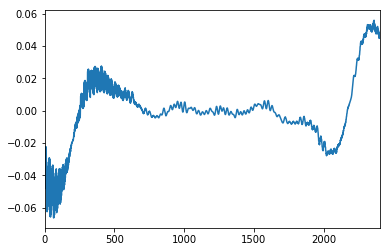

In [258]:
wavelet1 = pywt.cwt(sm[196][0:2400],200,"mexh")
plt.plot(wavelet1[0][0])
plt.xlim(0,2400)

Casting complex values to real discards the imaginary part


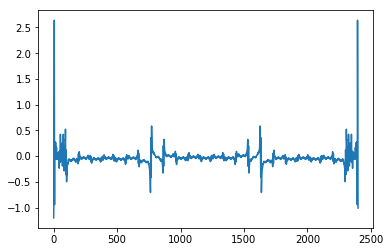

In [259]:
fourier1 = fft(wavelet1[0][0])
plt.plot(fourier1)

In [260]:
freq_cst = (1/(np.sqrt(2*np.pi)))

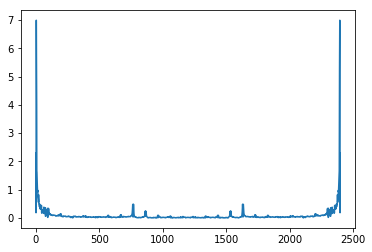

In [261]:
fourier1 = np.absolute(fourier1)
fourier1 = freq_cst*fourier1
plt.plot(fourier1)

(0, 10)

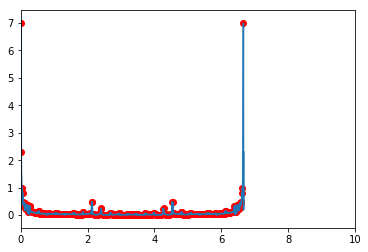

In [262]:
M = argrelextrema(fourier1,np.greater)[0]
plt.plot(time[0:len(fourier1)],fourier1)
plt.scatter(time[M],fourier1[M],color='red')
plt.xlim(0,10)

419

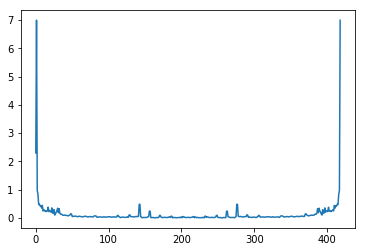

In [263]:
plt.plot(fourier1[M[0:2400]])
len(fourier1[M[0:2400]])

In [266]:
def SPEC2(signal):
    freq_1 = 0.5
    freq_2 = 9

    time_1 = 1/9
    time_2 = 1/0.5

    range1 = int(np.ceil(time_1*300))
    range2 = int(np.floor(time_2*300))

    fourier_3 = signal[range1:range2]
    
    m = np.amax(fourier_3)
    f = fourier_3.tolist()
    
    time_max_amp = f.index(m)/300 ## in seconds
    if time_max_amp != 0:
        God_of_War = 1/time_max_amp
    else:
        God_of_War = 0
    
    A3 = A3_calc(signal,God_of_War)
    
    return A3

In [267]:
SPEC2(fourier1[M[0:2400]])

NameError: name 'A3_calc' is not defined

In [268]:
def wavelet_one(signal):
    wavelet1 = pywt.cwt(signal,200,"mexh")
    fourier1 = fft(wavelet1[0][0])
    freq_cst = (1/(np.sqrt(2*np.pi)))
    fourier1 = np.absolute(fourier1)
    fourier1 = freq_cst*fourier1
    M = argrelextrema(fourier1,np.greater)[0]
    
    return SPEC2(fourier1[M[0:2400]])

In [270]:
wavelet_one(sm[196][0:2400])

NameError: name 'A3_calc' is not defined

## Wavelet 1 Extraction:

In [ ]:
def Wave1_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(wavelet_one(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

In [ ]:
Wave1_DF = Wave1_ext(ss)

## Wavelet 2 Algorithm:

Need to turn the SPEC algorithm into one big algorithm. This uses SPEC to check whether the signal is VF, if it is, then this second wavelet does not need to be considered. If it doesn't however, the following is performed:

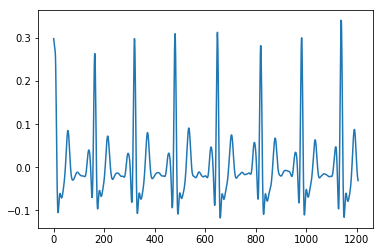

In [271]:
w = pywt.dwt(sm[196][0:2400],'db8','smooth')
plt.plot(w[0])

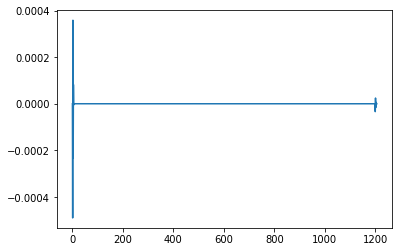

In [272]:
plt.plot(w[1])

In [273]:
qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=55)
len(qrs_wave2)/3

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

7.0

In [278]:
def Wave_2(signal):
    w = pywt.dwt(signal[0:2400],'db8','smooth')
    qrs_wave2 = processing.xqrs_detect(sig=w[0], fs=55)
    return len(qrs_wave2)/3

In [279]:
Wave_2(sm[196][0:2400])

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

7.0

## Wavelet 2 Extraction:

In [ ]:
def Wave2_ext(ss):
    values = []
    for i in range(len(ss)):
        for j in range(len(ss[i])):
            values.append(Wave_2(ss[i][j][0:2400]))
    v = np.array(values)
    v = pd.DataFrame(v)
    v.columns = ["SCA"]
    return v

# Parameter 10: Li Algorithm

I used the continuous wavelet instead, as it allows for scaling:

In [288]:
def wavelet_finder(signal):
    signal = wfdb.processing.normalize_bound(signal, lb=-1, ub=1)
    w1 = pywt.cwt(signal,2,'mexh')
    plt.plot(w1[0][0])
    
    w2 = pywt.cwt(signal,np.power(2,2),'mexh')
    plt.figure()
    plt.plot(w2[0][0])
    
    w3 = pywt.cwt(signal,np.power(2,3),'mexh')
    plt.figure()
    plt.plot(w3[0][0])
    
    w4 = pywt.cwt(signal,np.power(2,4),'mexh')
    plt.figure()
    plt.plot(w4[0][0])
    
    return w1[0][0],w2[0][0],w3[0][0],w4[0][0]

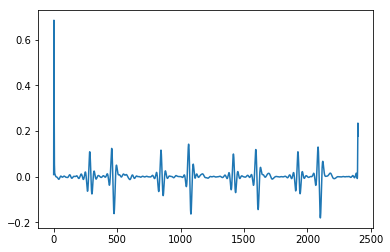

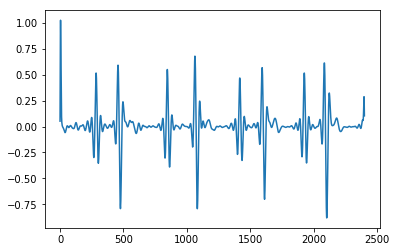

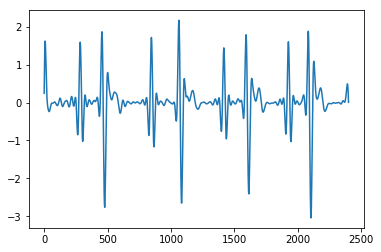

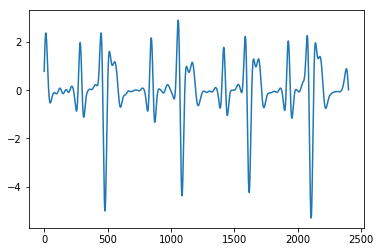

In [399]:
w1,w2,w3,w4 = wavelet_finder(sm[4519][0:2400])

In [400]:
w1,time1 = signal_preprocessor(w1,time1,30,30)
w2,time2 = signal_preprocessor(w2,time2,30,30)
w3,time3 = signal_preprocessor(w3,time3,30,30)
w4,time4 = signal_preprocessor(w4,time4,30,30)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [401]:
def QRS_number_search(w1,w2,w3,w4,fs):
    qrs_w1 = processing.xqrs_detect(sig=w1, fs=fs)
    qrs_w2 = processing.xqrs_detect(sig=w2, fs=fs)
    qrs_w3 = processing.xqrs_detect(sig=w3, fs=fs)
    qrs_w4 = processing.xqrs_detect(sig=w4, fs=fs)
    
    return qrs_w1,qrs_w2,qrs_w3,qrs_w4

In [402]:
qrs1,qrs2,qrs3,qrs4 = QRS_number_search(w1,w2,w3,w4,55)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an e

22.333333333333332
24.0
25.333333333333332
22.333333333333332


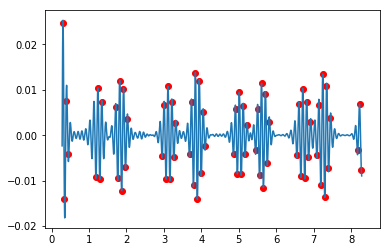

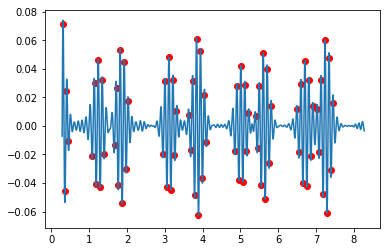

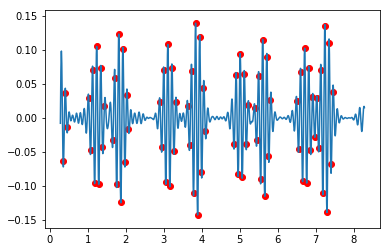

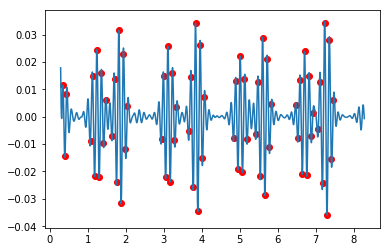

In [403]:
plt.plot(tm[196][0:2400],w1)
plt.scatter(tm[196][qrs1],w1[qrs1],color="red")
print(len(qrs1)/3)

plt.figure()

plt.plot(tm[196][0:2400],w2)
plt.scatter(tm[196][qrs2],w2[qrs2],color="red")
print(len(qrs2)/3)

plt.figure()

plt.plot(tm[196][0:2400],w3)
plt.scatter(tm[196][qrs3],w3[qrs3],color="red")
print(len(qrs3)/3)

plt.figure()

plt.plot(tm[196][0:2400],w4)
plt.scatter(tm[196][qrs4],w4[qrs4],color="red")
print(len(qrs4)/3)

0 or greater than 5 times the window length in seconds, so 40 in the 8 second interval case

# Parameter 11: Tompkins Algorithm

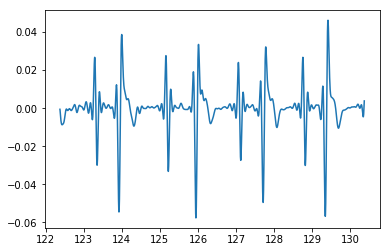

In [404]:
sig = np.gradient(sm[4519][0:2400],edge_order=1)
plt.plot(tm[4519][0:2400],sig)

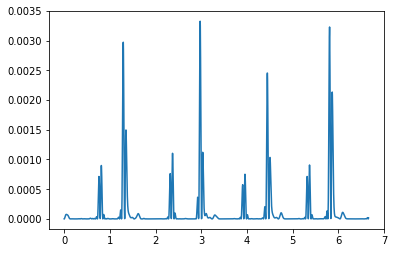

In [405]:
signal = np.power(sig,2)
plt.plot(time[0:2400],signal)

In [406]:
time2 = time[0:2400]
time2.shape

(2400,)

In [407]:
signal.shape

(2400,)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


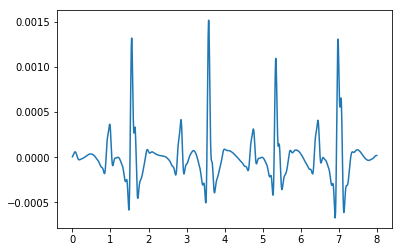

In [408]:
sigmig,time3 = signal_preprocessor(signal,time2,200,30)
sigmig = np.array(sigmig)
plt.plot(time3,sigmig)

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


11.666666666666666

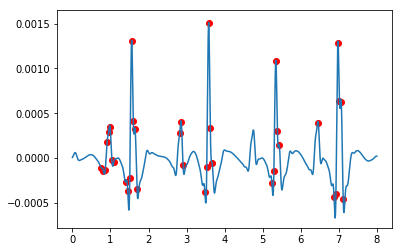

In [409]:
qrs = processing.xqrs_detect(sig=sigmig, fs=41)
plt.plot(time3,sigmig)
plt.scatter(time3[qrs],sigmig[qrs],color="Red")
len(qrs)/3

# Parameter 12: Mean Absolute Value Algorithm

In [183]:
def mav(signal,I1,I2):
    s = 0
    sig = signal/np.amax(np.absolute(signal))
    for i in sig[I1:I2]:
        s+=np.absolute(i)
    return s/len(signal)

In [184]:
mav(ss[2][0][0:2400],0,300)

0.02644043557461253

In [185]:
np.arange(0,int(len(ss[2][0][0:2400])/300)-1,1)

array([0, 1, 2, 3, 4, 5, 6])

In [186]:
def mav_avg(signal,length):
    L = (length-1)
    ran = np.arange(0,int(len(signal)/300)-2,1)
    I1 = 0
    I2= 600
    mavi = []
    for i in ran:
        mavi.append(7*mav(signal,I1,I2))
        I1+=300
        I2+=300
    avg_mav = np.mean(mavi)
    return avg_mav

In [187]:
mav_avg(ss[100][22][0:2400],2)

0.28161079226184715

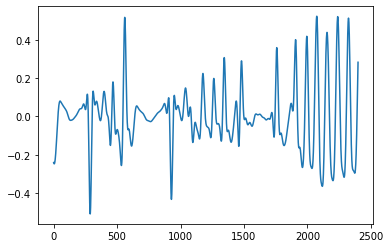

In [188]:
plt.plot(ss[100][22][0:2400])

Note that the threshold for VF-VT is 0.27

### Spectral Algorithm:

The only problem I have now is the calculation of the first spectral moment. I found some package that does it, but I'm not sure if it is the correct way. 

### Signal Comparison Algorithm:

How do I average the signals? The problem is that the QRS complexes... etc. are all at different indexes, which means that I can't average them. I triend using the starting point as the max before adding them, but that doesn't seem to work. Need something else.

# Fixes:

1. SPEC check which signal needs to be operated on and check the modulus 